### **Feature Engineering(타겟중점) 샘플링**


- **데이터 로드 및 샘플링**
    - 전체 데이터 200,000개
    - 나이가 20~40세인 20,000개의 데이터를 랜덤 샘플링
- **단위 변환**
    - `height` fit -> cm
    - `weight` lbs -> kg
- **결측치 처리** 
    - 숫자형: 평균값 (몸무게는 사이즈별 평균값)
    - 범주형: 최빈값
- **이상치 제거**
    - `height`, `weight`, `size`의 상위 1% 이상치 제거
- **나이 그룹화**
    - `age`, 쇼핑몰 타겟 대상인 20-30대 -> 4개 그룹화
- **전처리 및 가중치 적용**
    - 숫자형 데이터: 스케일링
    - 범주형 데이터: 원-핫 인코딩 후, 가중치 부여(각 범주형 피처-도메인 개수만큼 나누기, 합은 1)
- **t-SNE 차원 축소**: 데이터를 2D로 축소하여 시각화
- **엘보우 그래프**: K-Means 클러스터링으로 최적의 클러스터 수 찾기 -> k=6
- **결과 및 고려사항**
    - 실루엣점수: 0.363
    - t-SNE 군집화 준수
    - 대용량데이터에서 해당 결과는 유의미한 수준 결과로 판단 -> 전체데이터 적용 후 재확인 예정

샘플링된 데이터 크기: (20000, 15)

 몸무게와 사이즈의 상관관계: 0.854
이상치 제거 후 데이터 크기: (19490, 17)

 t-SNE 차원 축소 시작...


c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE 차원 축소 완료!

 엘보우 메서드로 최적 k값 탐색...
k=2: inertia = 54565856.00
k=4: inertia = 24835864.00
k=6: inertia = 16619832.00
k=8: inertia = 12152775.00
k=10: inertia = 9770921.00
k=12: inertia = 8077591.00
k=14: inertia = 6847734.00
k=16: inertia = 5959176.00
k=18: inertia = 5208994.00
k=20: inertia = 4670654.00
k=22: inertia = 4251188.00
k=24: inertia = 3840318.50


c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50648 (\N{HANGUL SYLLABLE EL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu San

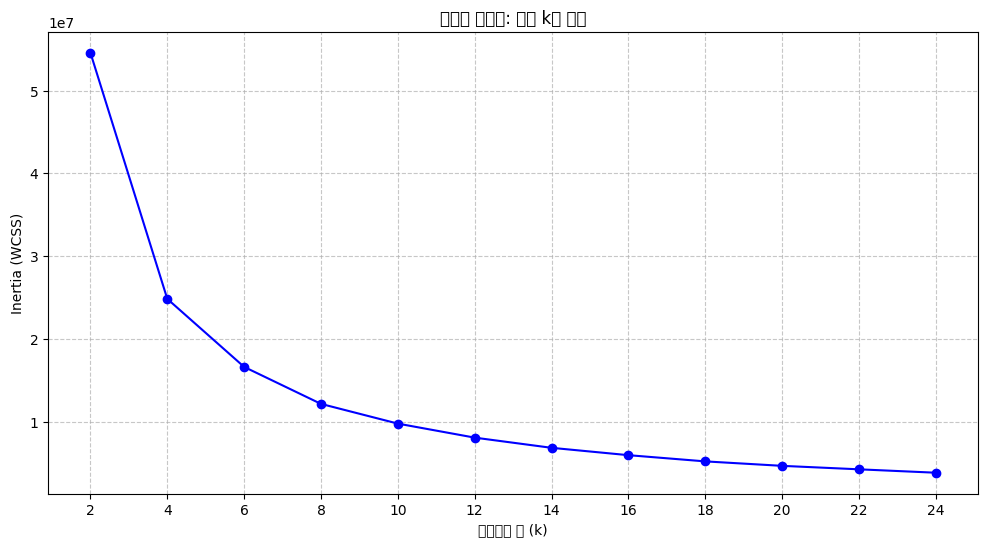

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

# 1. 데이터 로드 (에러 처리 추가)
try:
    df = pd.read_csv('../../renttherunway_data.csv')  # 파일 경로 확인 필수
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로를 확인해 주세요: ../../renttherunway_data.csv")
    exit()

# 2. 샘플링 및 필터링
df = df[(df['age'] >= 20) & (df['age'] < 40)]
df = df.sample(n=20000, random_state=42).reset_index(drop=True)
print(f"샘플링된 데이터 크기: {df.shape}")

# 3. 단위 변환 함수
def height_to_cm(height):
    try:
        if pd.isna(height): return np.nan
        feet, inches = height.split("'")
        inches = inches.replace('"', '').strip()
        return int(feet)*30.48 + int(inches)*2.54
    except:
        return np.nan

# 4. 단위 변환 적용
df['height_cm'] = df['height'].apply(height_to_cm)
df['weight_kg'] = df['weight'].astype(str).str.replace('lbs','').str.strip()
df['weight_kg'] = pd.to_numeric(df['weight_kg'], errors='coerce') * 0.453592

# 5. 몸무게-사이즈 상관관계 계산
correlation = df['weight_kg'].corr(df['size'])
print(f"\n 몸무게와 사이즈의 상관관계: {correlation:.3f}")

# 6. 결측치 처리 (사이즈별 평균 적용)
# 6-1. size, height_cm, age는 전체 평균으로 먼저 채우기
numeric_cols_except_weight = ['height_cm', 'size', 'age']
df[numeric_cols_except_weight] = df[numeric_cols_except_weight].fillna(df[numeric_cols_except_weight].mean())

# 6-2. weight_kg: 사이즈별 평균 → 전체 평균 순으로 채우기
size_weight_mean = df.groupby('size')['weight_kg'].transform('mean')
overall_weight_mean = df['weight_kg'].mean()
df['weight_kg'] = df['weight_kg'].fillna(size_weight_mean).fillna(overall_weight_mean)

# 6-3. 범주형 변수 처리
categorical_cols = ['body type']
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])


# 7. 이상치 제거 (상위 1% 제거)
for col in ['height_cm', 'weight_kg', 'size']:
    df = df[df[col] <= df[col].quantile(0.99)]
print(f"이상치 제거 후 데이터 크기: {df.shape}")

# 8. 나이 그룹화
df['age_group'] = pd.cut(df['age'], bins=[19, 25, 30, 35, 40], 
                         labels=['20-24', '25-29', '30-34', '35-39'])

# 9. 전처리 및 가중치 적용
scaler = MinMaxScaler()
num_features = scaler.fit_transform(df[['height_cm', 'weight_kg', 'size']])

encoder_age = OneHotEncoder(sparse_output=False)
age_encoded = encoder_age.fit_transform(df[['age_group']])
age_weights = np.ones(age_encoded.shape[1]) / age_encoded.shape[1]
age_encoded = age_encoded * age_weights

encoder_body = OneHotEncoder(sparse_output=False)
body_encoded = encoder_body.fit_transform(df[['body type']])
body_weights = np.ones(body_encoded.shape[1]) / body_encoded.shape[1]
body_encoded = body_encoded * body_weights

final_features = np.hstack([
    num_features,
    age_encoded,
    body_encoded
])

# 10. t-SNE 차원 축소
print("\n t-SNE 차원 축소 시작...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, 
            early_exaggeration=12, n_iter=1000, random_state=42)
tsne_features = tsne.fit_transform(final_features)
print("t-SNE 차원 축소 완료!")

# 11. 엘보우 메서드 (k=2~24, 2단위)
print("\n 엘보우 메서드로 최적 k값 탐색...")
inertias = []
k_range = range(2, 25, 2)  # 2,4,6,...,24

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=15, random_state=42)
    kmeans.fit(tsne_features)
    inertias.append(kmeans.inertia_)
    print(f"k={k}: inertia = {kmeans.inertia_:.2f}")

# 12. 엘보우 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xticks(k_range)
plt.xlabel('클러스터 수 (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('엘보우 메서드: 최적 k값 탐색')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()




 최적 k값: 6 

 KMeans 클러스터링 시작 (k=6)...
클러스터링 완료!
 실루엣 점수 (k=6): 0.363


C:\Users\user\AppData\Local\Temp\ipykernel_9804\4161377717.py:23: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.savefig(f'kmeans_k{optimal_k}_clusters.png', dpi=300)
C:\Users\user\AppData\Local\Temp\ipykernel_9804\4161377717.py:23: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'kmeans_k{optimal_k}_clusters.png', dpi=300)
C:\Users\user\AppData\Local\Temp\ipykernel_9804\4161377717.py:23: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.savefig(f'kmeans_k{optimal_k}_clusters.png', dpi=300)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) Deja

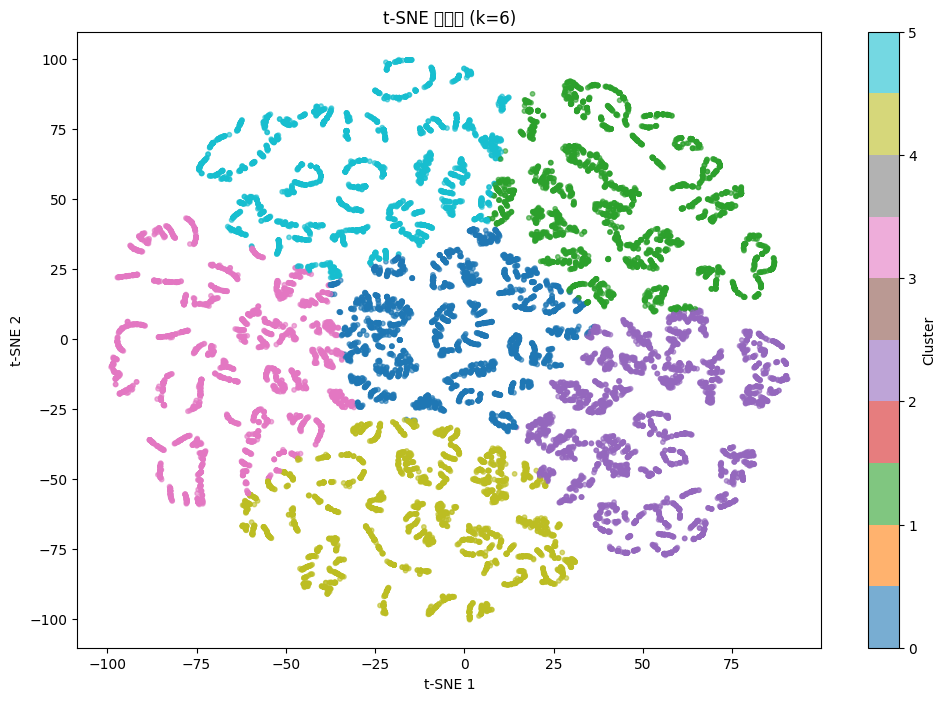

In [11]:
# 13. 최적 k값 선택
optimal_k = 6  # 그래프에서 확인 후 수정
print(f"\n 최적 k값: {optimal_k} ")

# 14. KMeans 클러스터링
print(f"\n KMeans 클러스터링 시작 (k={optimal_k})...")
kmeans = KMeans(n_clusters=optimal_k, n_init=15, random_state=42)
df['cluster'] = kmeans.fit_predict(tsne_features)
print("클러스터링 완료!")

# 15. 실루엣 점수 계산
silhouette = silhouette_score(tsne_features, df['cluster'])
print(f" 실루엣 점수 (k={optimal_k}): {silhouette:.3f}")

# 16. t-SNE 시각화
plt.figure(figsize=(12,8))
plt.scatter(tsne_features[:,0], tsne_features[:,1], 
            c=df['cluster'], cmap='tab10', alpha=0.6, s=10)
plt.colorbar(ticks=range(optimal_k), label='Cluster')
plt.title(f't-SNE 시각화 (k={optimal_k})')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig(f'kmeans_k{optimal_k}_clusters.png', dpi=300)
plt.show()



In [13]:
# 17. 군집별 추천
recommendations = {}
for cluster in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster]
    recommended_items = cluster_data[
        (cluster_data['fit'] == 'fit') & 
        (cluster_data['rating'] >= 4)
    ]['item_id'].value_counts().index.tolist()
    recommendations[cluster] = recommended_items[:30]

print("\n 군집별 추천 아이템 수:")
for cluster, items in recommendations.items():
    print(f"Cluster {cluster}: {len(items)}개")

# 18. 모델 저장
joblib.dump({
    'kmeans': kmeans,
    'scaler': scaler,
    'encoder_age': encoder_age,
    'encoder_body': encoder_body,
    'tsne': tsne,
    'optimal_k': optimal_k
}, f'optimal_kmeans_k{optimal_k}_model.pkl')

print("\n 모델 저장 완료!")

# 19. 군집 프로필
cluster_profile = df.groupby('cluster').agg({
    'height_cm': 'mean',
    'weight_kg': 'mean',
    'size': 'mean',
    'age': 'mean',
    'body type': lambda x: x.value_counts().index[0]
}).reset_index()

print("\n 대표적인 군집 프로필:")
print(cluster_profile)


 군집별 추천 아이템 수:
Cluster 0: 30개
Cluster 1: 30개
Cluster 2: 30개
Cluster 3: 30개
Cluster 4: 30개
Cluster 5: 30개

 모델 저장 완료!

 대표적인 군집 프로필:
   cluster   height_cm  weight_kg       size        age  body type
0        0  166.242708  61.391631  10.687219  31.570649   athletic
1        1  166.792933  68.683742  17.232339  33.042935  hourglass
2        2  166.796948  69.086927  17.562256  32.579006  hourglass
3        3  161.058068  53.643376   3.867210  27.670216     petite
4        4  167.457266  61.101283   9.659716  28.282261   athletic
5        5  164.976797  57.617487   6.351396  32.525266  hourglass



PCA 차원 축소 시작...
PCA 차원 축소 완료!


C:\Users\user\AppData\Local\Temp\ipykernel_9804\4138810495.py:16: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.savefig(f'pca_k{optimal_k}_clusters.png', dpi=300)
C:\Users\user\AppData\Local\Temp\ipykernel_9804\4138810495.py:16: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.savefig(f'pca_k{optimal_k}_clusters.png', dpi=300)
C:\Users\user\AppData\Local\Temp\ipykernel_9804\4138810495.py:16: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.savefig(f'pca_k{optimal_k}_clusters.png', dpi=300)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\toy3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.


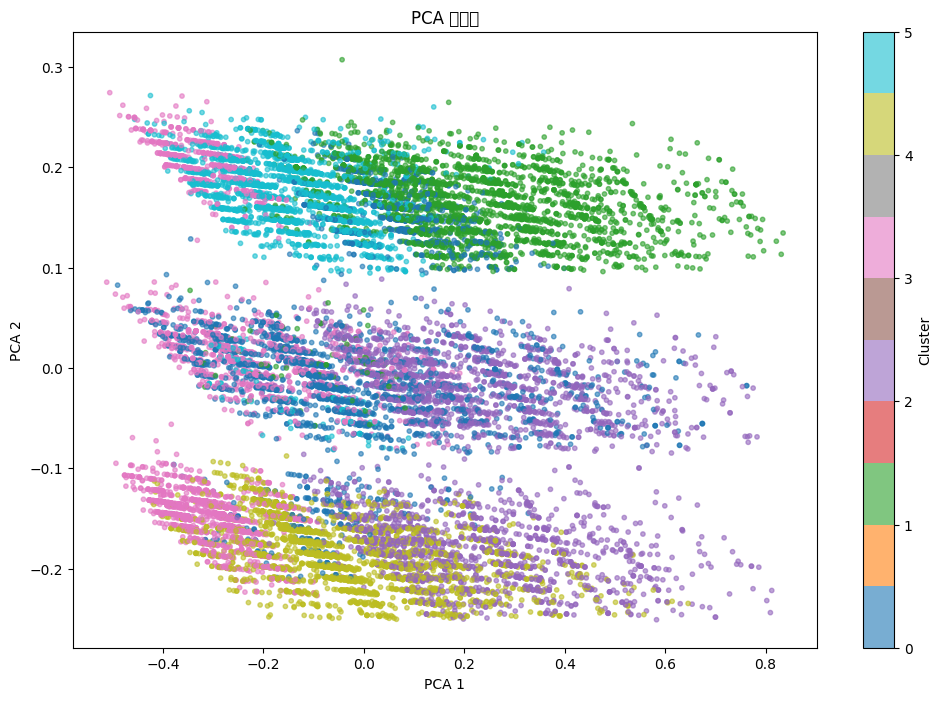

In [12]:
# 17. PCA 시각화
from sklearn.decomposition import PCA

print("\nPCA 차원 축소 시작...")
pca = PCA(n_components=2)
pca_features = pca.fit_transform(final_features)  # final_features 사용
print("PCA 차원 축소 완료!")

plt.figure(figsize=(12,8))
plt.scatter(pca_features[:,0], pca_features[:,1], 
            c=df['cluster'], cmap='tab10', alpha=0.6, s=10)
plt.colorbar(ticks=range(optimal_k), label='Cluster')
plt.title('PCA 시각화')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig(f'pca_k{optimal_k}_clusters.png', dpi=300)
plt.show()